In [121]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from MoleculeGeneration import *
from CreateInstanceGraph import get_instance_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
num_of_atoms = 20
basic_mols = [generateMoleculePart(100*i,num_of_atoms) for i in range(20)]
advanced_mols = [generateMoleculePart(10000*i,num_of_atoms) for i in range(20)]
# generují se basic a z nich advanced

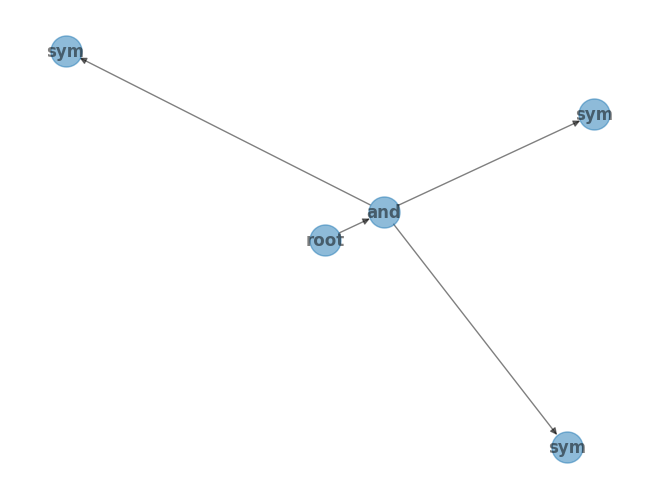

In [123]:
G = advanced_mols[3][1]
labels = nx.get_node_attributes(G, 'type')
nx.draw(G, labels=labels,
        node_size=500, alpha=0.5, font_weight="bold", arrows=True)
# advanced_mols - 3 je index molekuly a 1 je index tuplu na graf

[None, None]


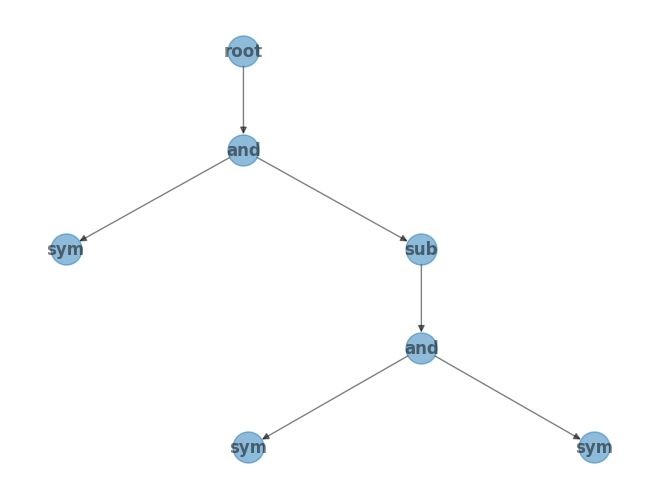

In [124]:
params,G = generateMolecule(advanced_mols,basic_mols)
pos = graphviz_layout(G, prog="dot")
labels = nx.get_node_attributes(G, 'type') 
nx.draw(G, pos=pos, labels=labels,
    node_size=500, alpha=0.5, font_weight="bold", arrows=True)
print(params)
# tady se generují kompozice

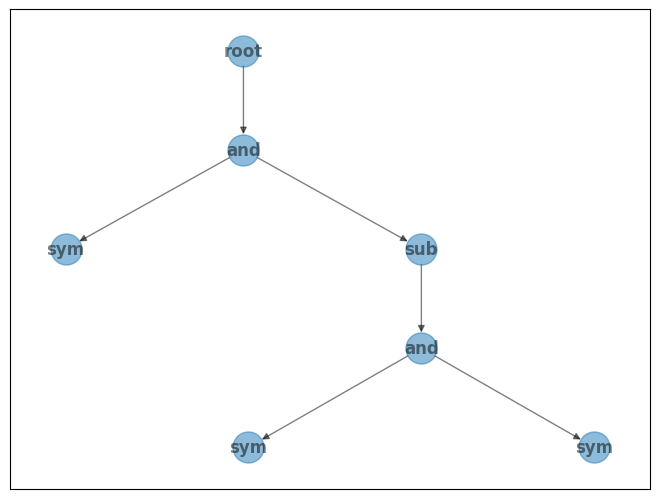

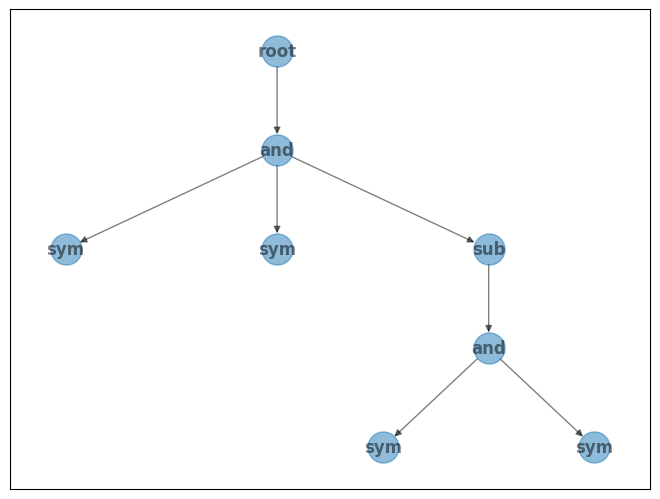

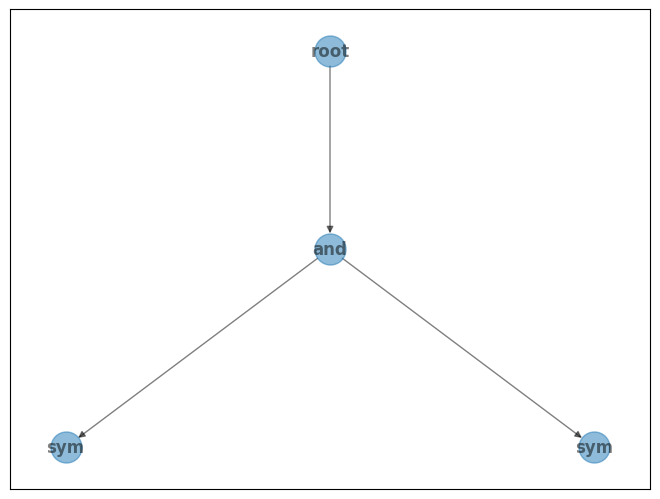

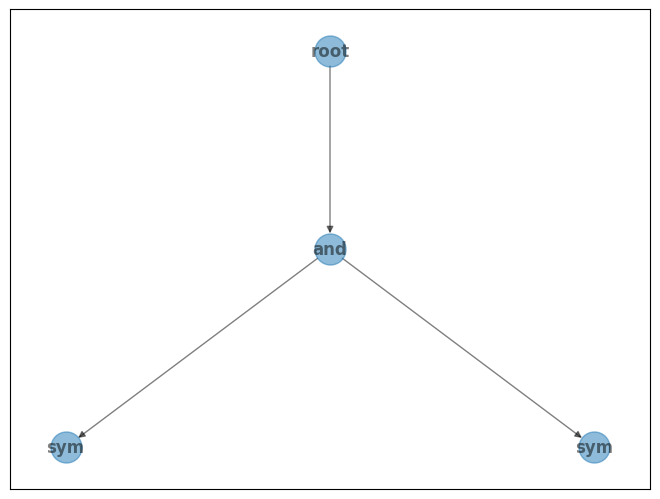

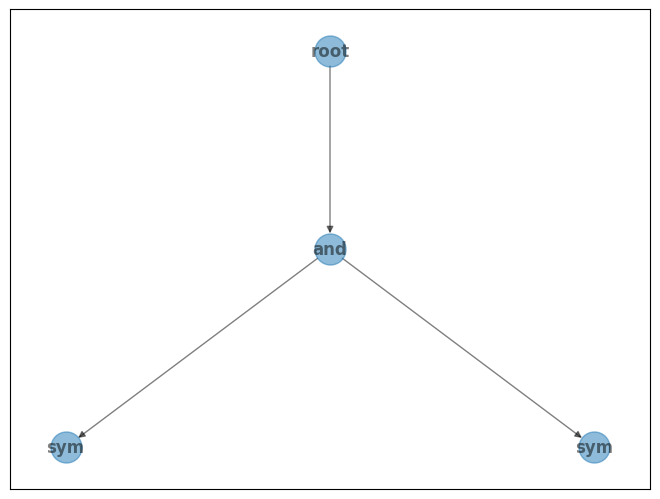

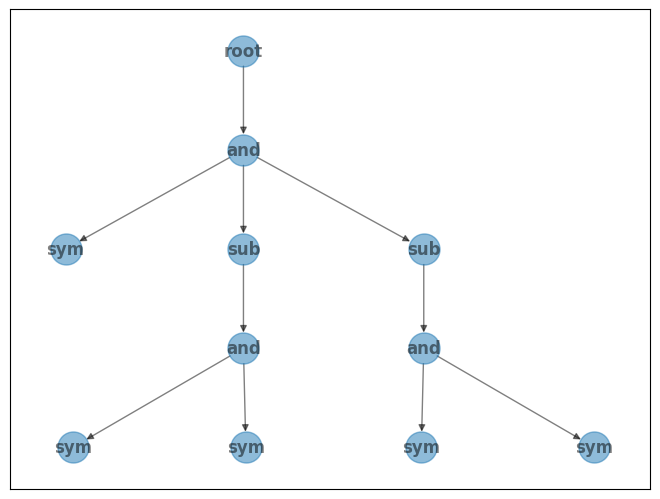

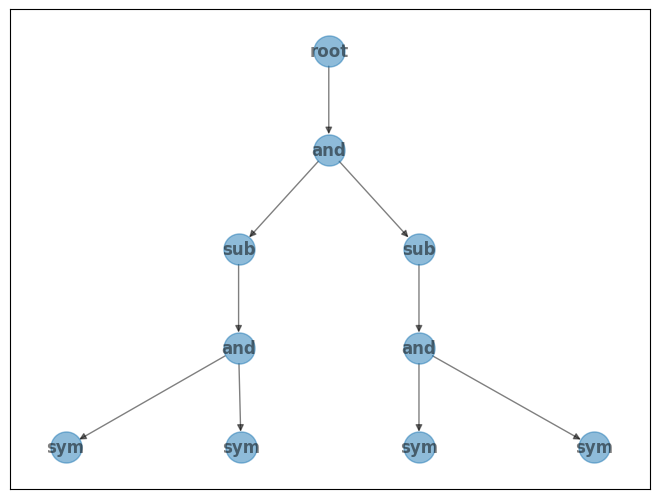

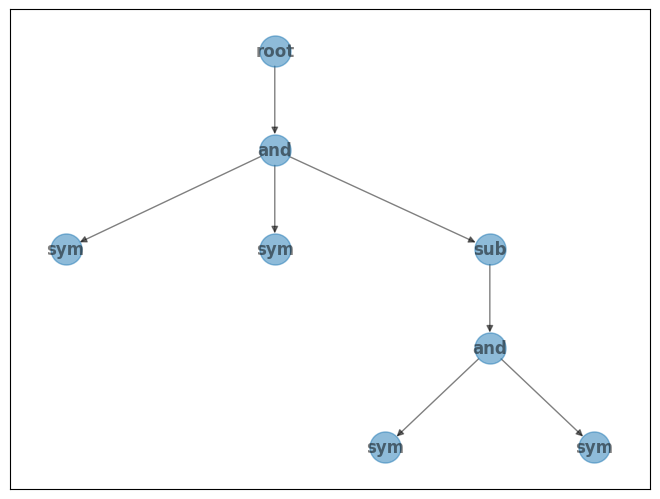

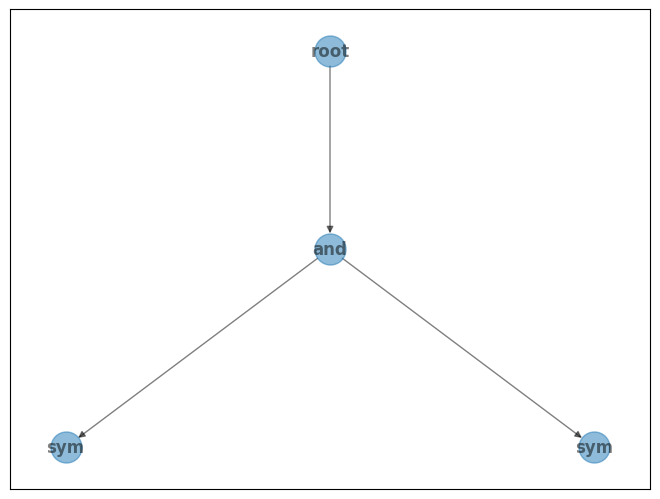

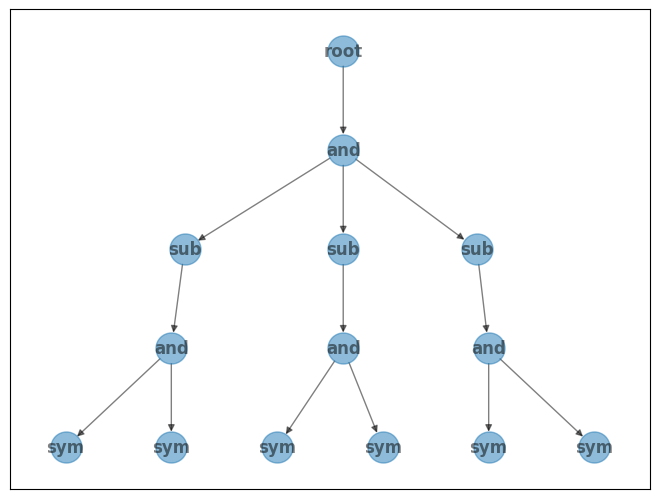

In [125]:
for i in range(10):
    params,G = generateMolecule(advanced_mols,basic_mols)
    pos = graphviz_layout(G, prog="dot")
    labels = nx.get_node_attributes(G, 'type')
    nx.draw(G, pos=pos, labels=labels,
        node_size=500, alpha=0.5, font_weight="bold", arrows=True)
    plt.axis('on')
    plt.show()

In [126]:
mols = {i:generateMolecule(advanced_mols,basic_mols) for i in range(50)}
instancesData = [generateInstanceData(mols) for i in range(500)]

In [127]:
instance = instancesData[4]
get_splited_molecules(instance)

{0: {'comps': [['0', '18', '8'], ['14']], 'doorTo': None},
 1: {'comps': [['18', '2']], 'doorTo': 0}}

In [128]:
instance

[{'obstacle_G_ix': None,
  'edge': None,
  'params': [None, None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x20cc740f048>,
  'molecule_ix': 47},
 {'obstacle_G_ix': 0,
  'edge': ('h501', 'h503'),
  'params': [None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x20cc6901b08>,
  'molecule_ix': 39}]

pointers,blocks = get_blocks(instance)

mol_ids = get_molecule_ids(instance)

mol_ids

merged_blocks = get_merged_blocks(blocks)

G,nodes_to_split = get_block_graph(merged_blocks,mol_ids)

nx.draw(G,with_labels = True)

G.nodes(data=True)

rnd.randint(0,0)

for node in G.nodes(data=True):
    data = node[1]['data']
    if type(data) != list:
        data = list(data.values())[0]
    data = split_to_rooms(data)
    G.nodes[node[0]]['data']=data

G.nodes(data=True)

instance

In [129]:
graph_instances_lst = []
for i, instance in enumerate(instancesData):
    try:
        g = get_instance_graph(instance)
        graph_instances_lst.append({"layout_spec":g, "molecules": instance})
    except:
        print(i)


27
71
84
93
111
121
124
125
196
260
298
303
364
369
400
444
471
481


In [134]:
import pickle
with open('graph_instances_lst.pkl', 'wb') as f:
    pickle.dump(graph_instances_lst, f)

with open("mols.pkl", "wb") as f:
    pickle.dump(mols, f)

In [131]:
G.edges(data=True)

OutEdgeDataView([('ggg30000', 'ggg30001', {}), ('ggg30001', 'ggh500', {}), ('ggg30001', 'gh1200', {}), ('ggg30001', 'h0', {}), ('ggh500', 'ggh501', {}), ('ggh501', 'ggh502', {}), ('ggh501', 'ggh503', {}), ('gh1200', 'gh1201', {}), ('gh1201', 'gh1202', {}), ('gh1201', 'gh1203', {}), ('h0', 'h1', {}), ('h1', 'h2', {}), ('h1', 'h3', {})])

In [132]:
for i in range(len(instance)):
    print(collect_symbols(instance[i]['molecule']))

[['4', '12', '2']]


In [133]:
for i in range(len(merged_blocks)):
    merged_blocks[i] 

NameError: name 'merged_blocks' is not defined

In [ ]:
mols[12][1].nodes(data=True)

In [ ]:
def generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used):
    num_ands = rnd.randint(2,3)
    G.add_node(last_ix+1,type='or',label='or')
    G.add_edge(pointer,last_ix+1)
    last_ix += 1
    pointer = last_ix
    for i in range(num_ands):
        last_ix,G = generateAnd(G,n_sym,last_ix,pointer,level,parameter,parameter_used,disj_used=True)
    return last_ix,G

def generateAnd(G,n_sym,last_ix,pointer,level,parameter=None,parameter_used=True,disj_used=False):
    disj = rnd.random() < 0.2 and not disj_used
    # generate Or node
    if disj:
        last_ix,G=generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used)     
    # generate And node
    else:
        G.add_node(last_ix+1,type='and',label='and')
        G.add_edge(pointer,last_ix+1)
        last_ix += 1
        pointer = last_ix
        num_syms = rnd.randint(2,3)
        # generate And descendants
        for i in range(num_syms):
            subgoal= rnd.random() < 0.2 and level < 1
            # generate subtree
            if subgoal:
                G.add_node(last_ix+1,type='sub',label=str(last_ix + 1))
                G.add_edge(pointer,last_ix+1)    
                last_ix,G = generateAnd(G,n_sym,last_ix+1,last_ix+1,level+1,parameter,parameter_used,disj_used=False)
            # generate leafs
            else:
                # first leaf should be parameter if the molecule is parametrized
                if not parameter_used:
                    G.add_node(last_ix+1,type='par',label=str(parameter))                    
                    G.add_edge(pointer,last_ix+1) 
                # normal symbol
                else:
                    sym = rnd.randint(0,n_sym)
                    in_par = sym  // 5 == parameter
                    # the symbol may be sampled from the range of the parameter
                    if in_par:
                        G.add_node(last_ix+1,type='par',label=str(parameter))
                    else: G.add_node(last_ix+1,type='sym',label=str(sym))                    
                    G.add_edge(pointer,last_ix+1) 
                last_ix += 1
            parameter_used = True
    return last_ix, G
        

def generateMolecule():
    # some molecules will be parametrized
    parametrized = rnd.random() < 0.2
    G = nx.DiGraph()
    last_ix = 21
    pointer = last_ix
    # root of the molecule
    G.add_node(last_ix,type='root')
    parameter = None
    if parametrized:
        # there are 5 types of parameters
        parameter = rnd.randint(0,4)
        ix,graph = generateAnd(G,20,last_ix,pointer,1,parameter,False)
    else:
        ix,graph = generateAnd(G,20,last_ix,pointer,1)
    return graph, parameter
    

In [ ]:
#ix,G,parameter = generateMolecule(1)
pos = graphviz_layout(G, prog="dot")
labels = nx.get_node_attributes(G, 'type') 
nx.draw(, pos=pos, with_labels=True,#labels=labels,
    node_size=500, alpha=0.5, font_weight="bold", arrows=True)
plt.axis('on')
plt.show()

In [ ]:
G_dict = {}
for x in range (0,30):
    G_dict[x]=nx.DiGraph()

In [ ]:
# atoms
def add_random_atoms(G_dict_param):
    and_node = "and"
    goal_node = "goal"
    for j in range(len(G_dict_param)):

        rnd_number1_group1 = rnd.randint(1, 5)

        G_dict_param[j].add_node(rnd_number1_group1, group=1)
        G_dict_param[j].add_node(and_node, type=1)
        G_dict_param[j].add_node(goal_node, type=3)
        G_dict_param[j].add_edge(rnd_number1_group1, and_node)
        G_dict_param[j].add_edge(and_node, goal_node)
        for k in range(rnd.randrange(1,5)):
            rnd_number2_group1 = rnd.randint(1, 5)
            G_dict_param[j].add_node(rnd_number2_group1)
            G_dict_param[j].add_edge(rnd_number2_group1, and_node)
    return G_dict_param

def create_new(n):
    and_node_1 = "and_1"
    and_node_2 = "and_2"
    and_nodes = [and_node_1, and_node_2]
    or_node = "or"
    goal_node = "goal"
    node_lst_to_connect = {}

    G_dict[n] = nx.DiGraph()

    G_dict[n].add_node(or_node, type=2)
    G_dict[n].add_node(and_node_1, type=1)
    G_dict[n].add_node(and_node_2, type=1)
    G_dict[n].add_node(goal_node, type=3)

    G_dict[n].add_edge(and_node_1, or_node)
    G_dict[n].add_edge(and_node_2, or_node)
    G_dict[n].add_edge(or_node, goal_node)
    counter=0
    counter2=0

    while len(G_dict[n].in_edges(and_node_1)) < rnd.randint(2,3):
        rnd_number1_group1 = rnd.randint(1, 5)
        G_dict[n].add_node(rnd_number1_group1, group=1)
        node_lst_to_connect[counter] = rnd_number1_group1
        node_to_add_1 = node_lst_to_connect.get(counter)
        counter += 1
        G_dict[n].add_edge(node_to_add_1, and_node_1)

    while len(G_dict[n].in_edges(and_node_2)) < rnd.randint(2,3):
        rnd_number2_group1 = rnd.randint(1, 5)
        G_dict[n].add_node(rnd_number2_group1, group=1)
        node_lst_to_connect[counter] = rnd_number2_group1
        node_to_add_1 = node_lst_to_connect.get(counter)
        counter2 += 1
        G_dict[n].add_edge(node_to_add_1, and_node_2)

    return G_dict[n]

def check_if_2_same_graphs_and_remove():
    for k in range(len(G_dict)):
        for j in range(len(G_dict)):
            if G_dict[k].nodes == G_dict[j].nodes and k != j:
                    del G_dict[j]
                    G_dict[j] = create_new(j)

In [ ]:
G_dict = add_random_atoms(G_dict)
check_if_2_same_graphs_and_remove()

In [ ]:
for i in range(len(G_dict)):
    nx.draw(G_dict[i], with_labels=True,
        node_size=1500, alpha=0.5, font_weight="bold", arrows=True,
        connectionstyle='arc3, rad = 0.1')
    print(i)
    plt.axis('on')
    plt.show()

In [ ]:
for i in range(len(G_dict)):
    nx.draw(G_dict[i], with_labels=True,
        node_size=1500, alpha=0.5, font_weight="bold", arrows=True,
        connectionstyle='arc3, rad = 0.1')
    print(i)
    plt.axis('on')
    plt.show()